#### Introduction
The performance of a model is dependent on how well it captures the surrounding noise 
and signal. Varying the lambda value and/or spline count impacts the effective degrees
freedom of the model (its complexity) and the models ability to fit the data. The 
optimal model parameters are therefore dependent on the quality of the data: a noisy
dataset will benefit from heavy smoothing (large lambda, low spline count), while 
datasets with less noise do not need as much smoothing. Other factors such as the 
complexity of the trend and length of the analysis period could also impact the model 
parameters. In this section all models will be evaluated by comparing the performance 
metrics (RMSE, ME and correlation coefficient) against the model input parameters 
(lambda and spline count) through a series of vsiuals. In addition to model 
performance, visualising the data in this way gives a sense of the model stability (ie. 
for how many orders of magnitude the results are consistent).

#### Aim
To identify the best models for predicting baseline values. 

#### Workflow
1) The main dataset is filtered to acquire the actual baselines. These will be used to 
evaluate the accuracy of the model predictions. 
2) The residuals for each model (actual baseline - predicted baseline) are computed. 
3) The performance metrics are computed from the residuals. 
4) The performance metrics for each model are visualised in terms of lambda and spline
count. 

In [2]:
# Importing packages
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# Importing data
# Prediction data holds the baseline site index predictions from the site/species level GAM
with open(project_root/'Data'/'UKBMS'/'gam_optimisation'/'obs_12_13_14'/'obs_12_13_14_parameters.pkl','rb') as file:
    obs_12_13_14_parameters = pickle.load(file)

# contains the actual baseline values needed for the comparison
actual_data = pd.read_csv(project_root/'Data'/'UKBMS'/'ukbms_master_v1.csv', index_col=0)

#### Acquiring the Actual Baseline Values

In [3]:
actual_baseline = actual_data[(actual_data['year']==1993)]

In [4]:
# Filtering to only baselines that match the site/species combinations in the parameters 
# dictionary containing the predictions.
# Only matching site/species combinations will remain.
results = {}
for key, value in obs_12_13_14_parameters.items():
    results[key] = (
        value.merge(actual_baseline,
                    how='inner',
                    on=['species_code', 'site_code'])
    )

In [5]:
# Removing redundant columns from predictions dataframes in 'results' dictionary
for key, value in results.items():
    results[key] = (
        value.drop(columns=['country',
                            'site_name',
                            'species',
                            'common_name',
                            'gridreference',
                            'easting',
                            'northing'])
    )

In [6]:
# Log transforming actual indices using log1p().
# log1p() is the same as log(x+1). It enables the inclusion of zero values. 
# Indices are transformed due to a large right-skew in the data. 
for key, value in results.items():
    results[key] = value.assign(
        actual_log=np.log1p(value['site_index'])
    )

#### Computing the Residuals and Performance Metrics

In [7]:
# Computing the prediction performance metrics of interest
parameter_list = []
corr_coeff = [] # correlation coefficient
rmse = [] # root mean square error
mae = [] # mean absolute error
me = [] # mean error
mean_edof = [] # mean effective degrees of freedom
for key, value in results.items(): # loops through each set of parameter predictions
    corr_coeff.append( # correlation between actual and predicted values
        round(value['actual_log']
              .corr(value['prediction_data']),4)
    )
    residuals = value['actual_log']-value['prediction_data']
    n = len(value) # number of rows
    rmse.append(round(np.sqrt((np.sum((residuals)**2))/n),4))
    me.append(round(np.sum(residuals)/n,4))
    mae.append(round(np.sum(abs(residuals))/n,4))
    mean_edof.append(round(np.mean(value['edof']),4))
    # model parameters are added to 'parameter_list' every loop
    parameter_list.append(key) 

In [8]:
# Creating a dataframe with all the populated metric lists 
# Each line represents a different combination of parameters
parameter_metrics = pd.DataFrame({'parameters':parameter_list,
                                 'corr_coeff':corr_coeff,
                                 'rmse':rmse,
                                 'mae':mae,
                                 'me':me,
                                 'mean_edof':mean_edof})

In [9]:
# Generating a lambda column
parameter_metrics['log10_lam'] = (
    # extracting the first tupple from 'parameters' column
    parameter_metrics['parameters'].str[0] 
)

# Generating a spline count column
parameter_metrics['splines'] = (
    # extracting the second tupple from 'parameters' column
    parameter_metrics['parameters'].str[1]
)

#### Visualising the Performance Metrics

In [10]:
# Before visualising, must convert spline values from continuous to categorical type. 
# seaborn displays in different colours. 
parameter_metrics['splines'] = parameter_metrics['splines'].astype('category')

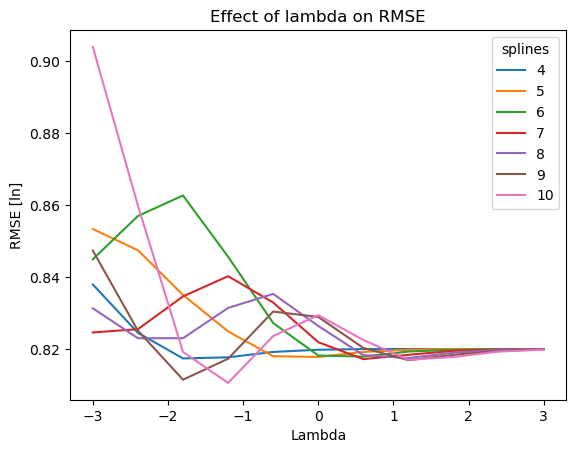

In [11]:
# Visualising the effect of lambda on RMSE for different spline counts
# Importing the required packages
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf() # clears previous plot

sns.lineplot(data=parameter_metrics,
             x='log10_lam',
             y='rmse',
            hue='splines') # different colour for different spline counts

plt.xlabel('Lambda')
plt.ylabel('RMSE [ln]')
plt.title('Effect of lambda on RMSE')

plt.show()

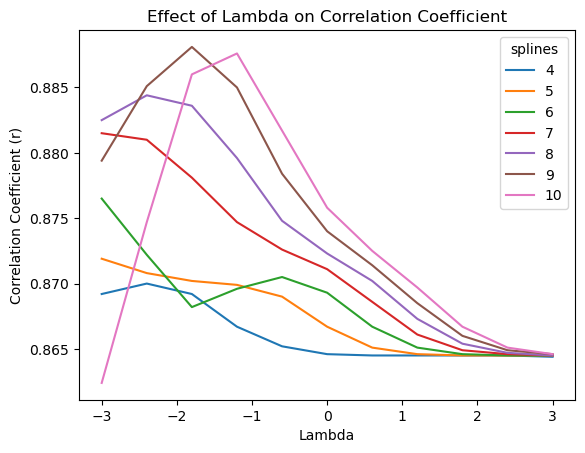

In [12]:
# The effect of lambda on correlation coeffcient for different spline counts
plt.clf() # clears previous plot

sns.lineplot(data=parameter_metrics,
            x='log10_lam',
            y='corr_coeff',
           hue='splines') # different colour for different spline counts

plt.xlabel('Lambda')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Effect of Lambda on Correlation Coefficient')

plt.show()

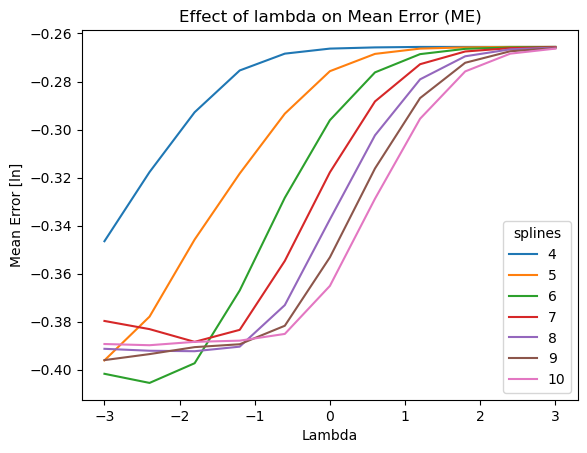

In [13]:
# The effect of lambda on Mean Error for different spline counts
plt.clf() # clears previous plot

sns.lineplot(data=parameter_metrics,
            x='log10_lam',
            y='me',
           hue='splines') # different colour for different spline counts

plt.xlabel('Lambda')
plt.ylabel('Mean Error [ln]')
plt.title('Effect of lambda on Mean Error (ME)')

plt.show()

#### Takeaways
- Model with parameters: k=4, lambda=0.6 appears to be optimal.
- Shows smallest correlation coefficient, but has lowest mean error across a large range
of lambda and good RMSE.
- Good stability between lambda=-0.6 and lambda=3.